# Parametric ULOFF in a Molten Salt Fast Reactor

The pump failure scenario is a transient scenario where the pump stops working and the flow of fuel salt in the primary loop is interrupted, in particular the momentum source in the model decays exponentially following 
\begin{equation*}
f(t; \tau) = f_0 \exp\left(-\frac{t}{\tau}\right)
\end{equation*}

Different simulation data have been generated considering different values of the decay time $\tau \in [1, 10]$ with a physical time of 30 seconds.

In this notebook, the snapshots of the simulation data have already been decomposed using the SVD with rank $r=40$, they are loaded from the D2 dataset.

At first, the spatial nodes can be loaded

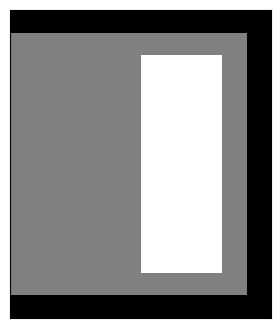

In [4]:
import pickle


domain_plot = pickle.load((open("../../NuSHRED_Datasets/D2/domain.pkl", "rb")))

from plots import get_msfr_geometry
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(4, 4))
get_msfr_geometry(axs)

There are 2 regions in the domain: gray the liquid core and black the solid reflector.

In [5]:
_, params, var_names, is_vector, fom_times, rescaling_snaps, Nmodes = pickle.load(open('../../NuSHRED_Datasets/D2/msfr_p.uloff', 'rb'))

Let us plot the parametric variation of the pump decay

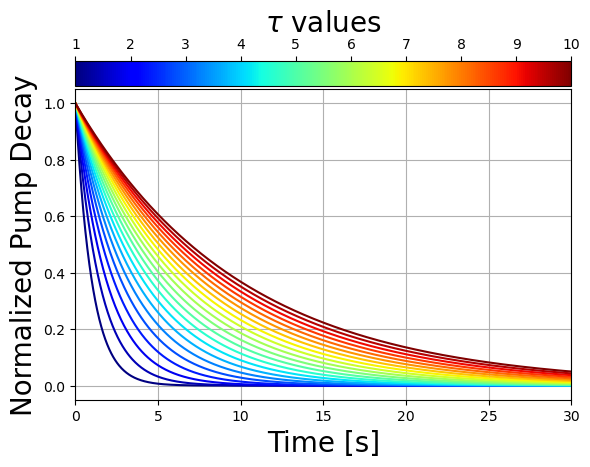

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

_time = np.linspace(0,30,1000)
_uloff_decay = lambda t, tau: np.exp(-t/tau)

_tau = params

colors = cm.jet(np.linspace(0,1,len(_tau)))
fig, ax = plt.subplots()
for i, tau in enumerate(_tau):
    ax.plot(_time, _uloff_decay(_time, tau), color=colors[i])
ax.grid()
ax.set_xlabel('Time [s]', fontsize=20)
ax.set_ylabel('Normalized Pump Decay', fontsize=20)
ax.set_xlim([0,30])

# Create a ScalarMappable for colorbar
sm = plt.cm.ScalarMappable(cmap=cm.jet, norm=plt.Normalize(vmin=_tau.min(), vmax=_tau.max()))
sm.set_array([])  # Required for colorbar

# Add colorbar horizontally at the top right
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', pad=0.01, aspect=20, shrink = 1.0, location = 'top')
cbar.set_label(r'$\tau$ values', fontsize=20)

The SVD modes, the singular values and the coefficients are stored in dictionaries.

In [8]:
svd_basis = {
    field: pickle.load(open(f'../../NuSHRED_Datasets/D2/CompressedDataset/pod_basis_{field}.svd', 'rb')) for field in var_names
}
svd_sing_vals = {
    field: np.diag(pickle.load(open(f'../../NuSHRED_Datasets/D2/CompressedDataset/sing_vals_{field}.svd', 'rb'))) for field in var_names
}
svd_coeff = pickle.load(open('../../NuSHRED_Datasets/D2/CompressedDataset/v_POD_all_fields.svd', 'rb'))

Let us plot the first 4 modes

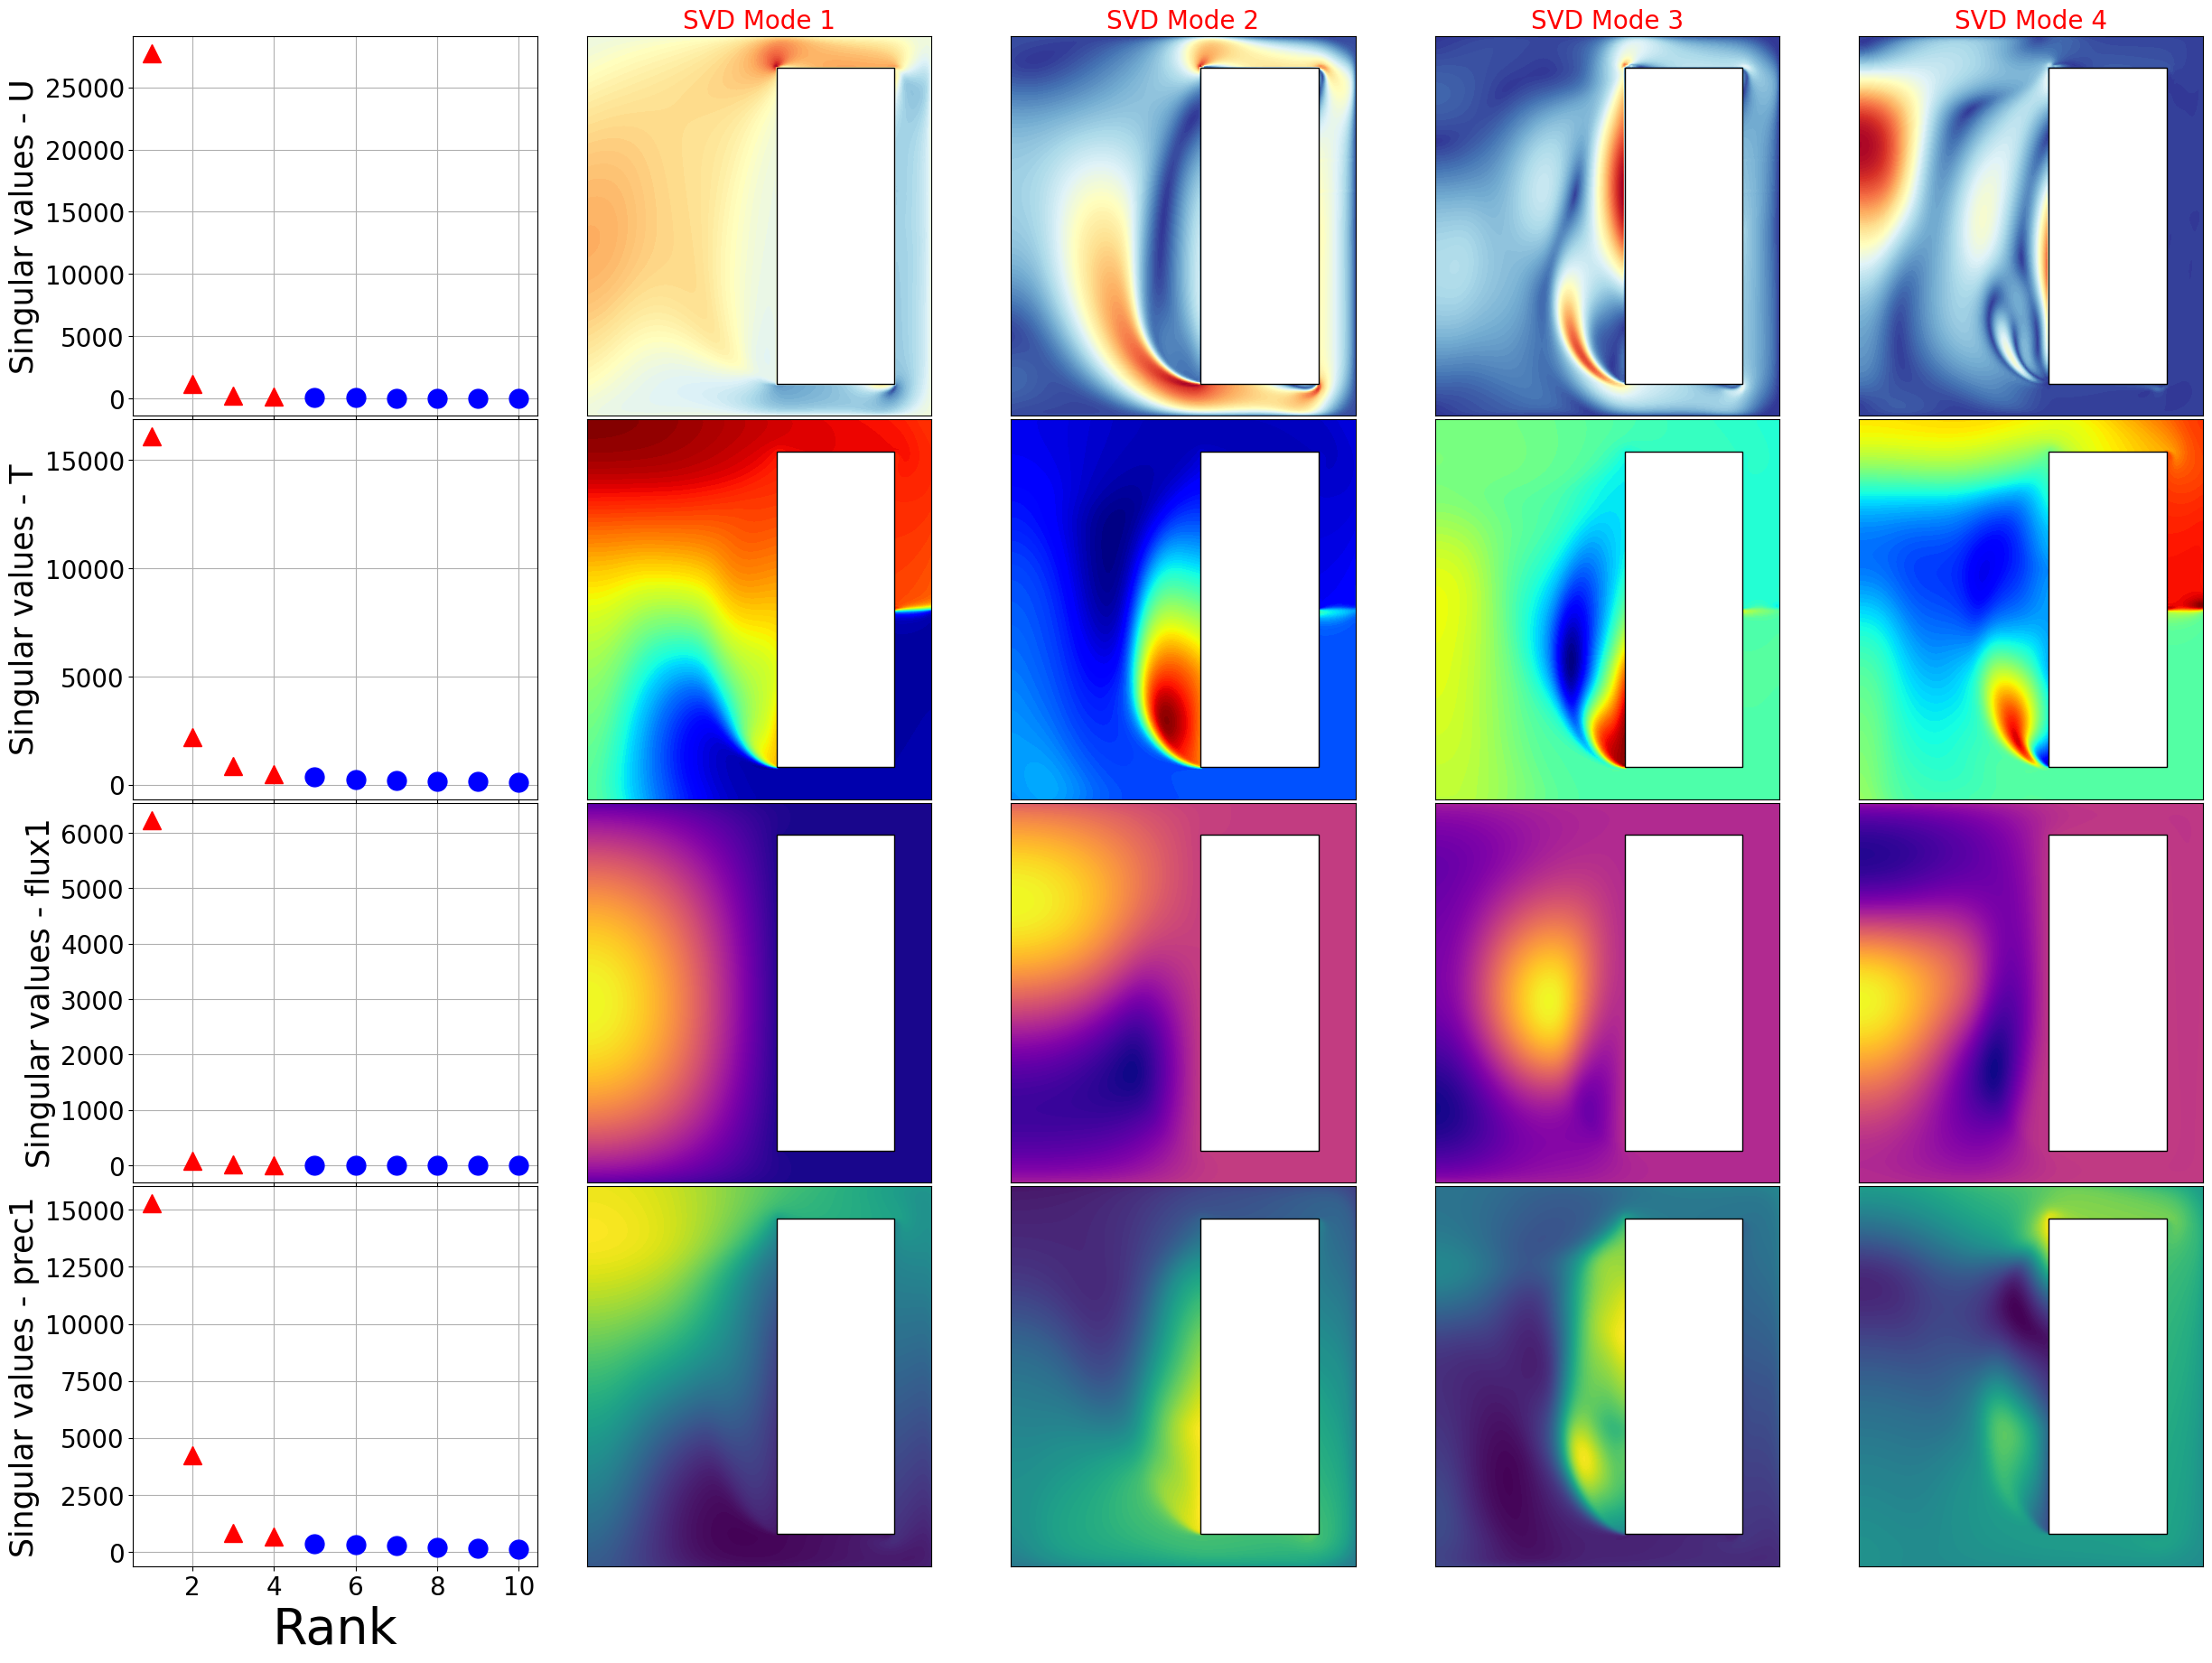

In [9]:
from plots import plot_contour

cmaps = [
            cm.RdYlBu_r,
            cm.jet,
            cm.plasma,
            cm.viridis
        ]

vars_to_plot = [0,1,3,9]

nrows = len(vars_to_plot)
ncols = 5
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*6,nrows*5.5))

for i, field_i in enumerate(vars_to_plot):

    vec_mode_to_plot = 'Mag' if field_i == 0 else None
    field = var_names[field_i]
    axs[i, 0].plot(np.arange(ncols,11,1), svd_sing_vals[field][ncols-1:10], 'bo', markersize=15)
    axs[i, 0].plot(np.arange(1,ncols,1), svd_sing_vals[field][:ncols-1], 'r^', markersize=15)

    axs[i, 0].tick_params(axis='both', which='major', labelsize=20)
    axs[i, 0].set_ylabel(r'Singular values - '+var_names[field_i]+'', fontsize=25)
    axs[i, 0].grid()

    for rr in range(ncols-1):
        mode = svd_basis[field][:,rr]
        plot_contour(axs[i, rr+1], domain_plot, mode, vec_mode_to_plot, cmaps[i], levels=100,
                     streamline_plot=False)

        # axs[i, rr+1].set_title(r'SVD Mode '+str(rr+1)+r' - $'+tex_var_names[field_i]+'$', fontsize=25, color='red')
        if i == 0:
            axs[i, rr+1].set_title(r'SVD Mode '+str(rr+1), fontsize=20, color='red')

for ax in axs[:,0]:
    ax.tick_params(axis='both', which='major', labelsize=20)

axs[-1, 0].set_xlabel('Rank', fontsize=40)

fig.subplots_adjust(hspace=0.01, wspace=0.05)


Let us make a plot of some fields over time

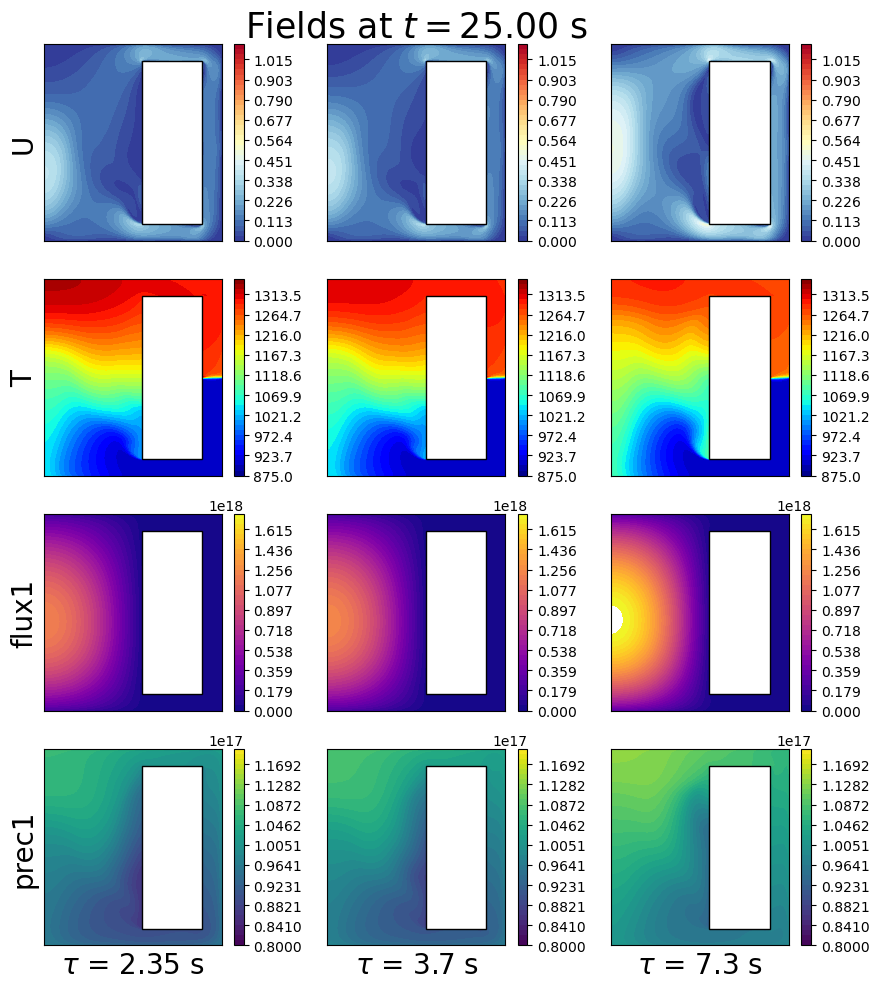

In [10]:
import warnings
from IPython.display import clear_output

warnings.filterwarnings('ignore')

params_to_plot = np.sort(np.random.choice(len(params), size=3, replace=False))


levels = [
    np.linspace(0, 1.1, 40),
    np.linspace(875, 1350, 40),
    np.linspace(0, 2e18,40),
    np.linspace(0.8e17, 1.2e17,40),
]

nrows = len(vars_to_plot)
ncols = len(params_to_plot)

for tt in range(49, len(fom_times), 150):

    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*3, nrows*2.5))

    for jj, field_i in enumerate(vars_to_plot):
        for i, param_i in enumerate(params_to_plot):
            vec_mode_to_plot = 'Mag' if field_i == 0 else None
            field = var_names[field_i]
            
            # Reconstruct the field - before compression they have been scaled with respect to the critical condition
            fom = rescaling_snaps[field_i].inverse_transform(
                np.linalg.multi_dot([svd_basis[field], np.diag(svd_sing_vals[field]), svd_coeff[field][param_i,tt].T]).reshape(-1,1)
            )

            cont = plot_contour(axs[jj, i], domain_plot, fom.flatten(), vec_mode_to_plot, cmaps[jj], levels=levels[jj],
                                streamline_plot=False)

            if jj+1 == nrows:        
                axs[jj, i].set_xlabel(r'$\tau$ = '+str(np.round(params[param_i,0], 2))+' s', fontsize=20)

            fig.colorbar(cont, ax=axs[jj, i], orientation='vertical')

        axs[jj, 0].set_ylabel(var_names[field_i], fontsize=20)

    axs[0,1].set_title(r'Fields at $t = {:.2f}$ s'.format(fom_times[tt]), fontsize=25)
    plt.tight_layout()

    plt.show()
    clear_output(wait=True)
    plt.close(fig)

# Singular Value Decomposition

In this notebook, from the already computed SVD we are going to retain only the dominant modes for the training of the SHRED architectures.

Let us define the train,test, valid sets

Define train, test and valid sets


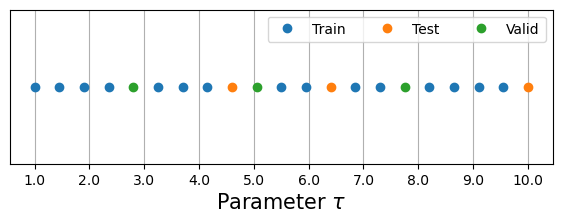

In [12]:
import os

print('Define train, test and valid sets')
np.random.seed(25)

ntrajectories = len(params)
ntrain = int(0.75 * ntrajectories)

idx_train = np.random.choice(ntrajectories, size = ntrain, replace = False)
mask = np.ones(ntrajectories)
mask[idx_train] = 0
idx_valid_test = np.arange(0, ntrajectories)[np.where(mask!=0)[0]]
idx_valid = idx_valid_test[::2]
idx_test = idx_valid_test[1::2]

nvalid = idx_valid.shape[0]
ntest = idx_test.shape[0]

fig, axs = plt.subplots(figsize=(7,2))

axs.plot(idx_train+1, np.ones_like(idx_train), 'o', label = 'Train')
axs.plot(idx_test+1,  np.ones_like(idx_test),  'o', label = 'Test')
axs.plot(idx_valid+1, np.ones_like(idx_valid), 'o', label = 'Valid')

axs.set_xlabel(r'Parameter $\tau$', fontsize=15)
# axs.set_xticks(np.arange(1,len(params)+1,2), params.flatten()[::2])
axs.set_xticks(np.linspace(1, len(params), 10), np.round(np.linspace(1, 10, 10), 2))
axs.set_yticks([])
axs.grid()
axs.legend(ncols=3)

path='./OfflineSVD/'
os.makedirs(path, exist_ok=True)


Let us load the snapshots, perform the SVD and save the data

In [22]:
n_separation = {
    'train': idx_train,
    'test':  idx_test,
    'valid': idx_valid
}

Nmodes = []
s_total = dict()
_v_POD = dict()

for field_i, field in enumerate(var_names):

    # Define Modes
    _Nmodes = 10
    Nmodes.append(_Nmodes)

    # Retain the first SVD modes

    pod_basis = svd_basis[field][:,:_Nmodes]
    s_total[field] = svd_sing_vals[field][:_Nmodes]
    
    # Generate POD Coefficients and errors
    _v_POD[field] = dict()

    for key in list(n_separation.keys()):
        _v_POD[field][key] = svd_coeff[field][n_separation[key],:,:_Nmodes]

    # Store the POD basis and singular values
    pickle.dump(pod_basis, open(path+'pod_basis_'+field+'.svd', 'wb'))
    pickle.dump(s_total[field], open(path+'sing_vals_'+field+'.svd', 'wb'))
    
Nmodes = np.asarray(Nmodes)

Plot the singular values

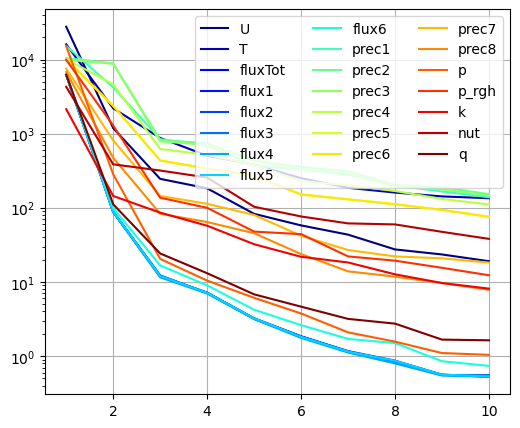

In [23]:
from matplotlib import cm

fig, axs = plt.subplots(nrows = 1, ncols = 1, sharex=True, figsize=(6,5))
axs = [axs]
colors = cm.jet(np.linspace(0,1,len(var_names)))
for field_i, field in enumerate(var_names):
    N_plot = np.arange(1, Nmodes[field_i]+1, 1)
    axs[0].semilogy(N_plot, s_total[field], color=colors[field_i], label=field)
axs[0].grid()
axs[0].legend(ncols=3)

Let us reshape the POD coefficients

In [25]:
Nt = len(fom_times)

v_POD = dict()
for key in list(n_separation.keys()):
    v_POD[key] = np.concatenate([_v_POD[var_names[field_i]][key].reshape(len(n_separation[key]), Nt, Nmodes[field_i]) 
                                for field_i in range(len(var_names))], axis=-1)

pickle.dump(v_POD, open(path+'v_POD.svd', 'wb'))

In the end, let us store some useful quantities

In [26]:
pickle.dump([n_separation, params, var_names, is_vector, fom_times, rescaling_snaps, Nmodes], open(path+'msfr_p.uloff', 'wb'))